<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preliminary-Imports" data-toc-modified-id="Preliminary-Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preliminary Imports</a></span></li><li><span><a href="#Data-Acquisition" data-toc-modified-id="Data-Acquisition-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Acquisition</a></span></li><li><span><a href="#Initial-Data-Exploration" data-toc-modified-id="Initial-Data-Exploration-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Initial Data Exploration</a></span></li><li><span><a href="#Removing-&amp;-Renaming-Columns" data-toc-modified-id="Removing-&amp;-Renaming-Columns-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Removing &amp; Renaming Columns</a></span></li><li><span><a href="#Data-Visualization" data-toc-modified-id="Data-Visualization-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Data Visualization</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Feature Engineering</a></span><ul class="toc-item"><li><span><a href="#Creating-Lags" data-toc-modified-id="Creating-Lags-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Creating Lags</a></span></li></ul></li><li><span><a href="#Get--market-sentiment-data" data-toc-modified-id="Get--market-sentiment-data-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Get  market sentiment data</a></span></li><li><span><a href="#The-Response-Variable" data-toc-modified-id="The-Response-Variable-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>The Response Variable</a></span></li><li><span><a href="#Handling-Missing-Data" data-toc-modified-id="Handling-Missing-Data-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Handling Missing Data</a></span><ul class="toc-item"><li><span><a href="#Filtering-missing-data" data-toc-modified-id="Filtering-missing-data-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Filtering missing data</a></span></li></ul></li><li><span><a href="#Export-final-pandas-DataFrame-to-csv" data-toc-modified-id="Export-final-pandas-DataFrame-to-csv-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Export final pandas DataFrame to csv</a></span></li></ul></div>

### Preliminary Imports

In [1]:
#Import preliminary libraries need to intiate project

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Embed generated plots directly within notebook output cells
%matplotlib inline 

### Data Acquisition 

Selected stock data: **Ekso Bionics Holdings, Inc**


Before, fetching the data, I will do a quick exploration using the *yfinance* library. My aim is specifically to get insights on stock splits. Since we are dealing with time-series data, this split might significantly affect our prediction. Especially if there has been a sharp change in the price.


Additionally , I will save this data to a local directory.

Below, I am going through the process of: 

- Obtaining relevant company information from the EKSO stock ticker using the yfinance library.

- Converting this information into a JSON format that is easily readable and portable across different systems.

- Saving the JSON data into a file named "ekso_info.json" for later use or analysis.

- Obtaining and saving the information on stock split dates into a csv.

In [2]:
# Create a ticker object for EKSO
ekso = yf.Ticker("EKSO")

# Get all stock info and save it into a json file calle "ekso_info" for later
info = ekso.info
import json

with open("ekso_info.json", "w") as f:
    json.dump(info, f)
    

# Get all stock split info as of the capture date and save it into csv file called "ekso_splits_info" for later
splits_data = pd.DataFrame(ekso.splits)
splits_data.to_csv("ekso_splits_data.csv") 

In [3]:
# Open the "ekso_splits_data.csv" to check the date of the last split
ekso_splits_data = pd.read_csv("ekso_splits_data.csv")
ekso_splits_data

,Date,Stock Splits
0,2016-05-05 00:00:00-04:00,0.142857
1,2020-03-25 00:00:00-04:00,0.066667


- The stock split is within the 5 year window of time I was considering, therefore we need to determine if we can just use the data after the split. 


- The last split happened in 2020, if we pull just all data after the split, that is 4 years. This should still be sufficient for our use case.

**NOTE** 

- I later modified this to pull 10 years worth of data. Since I am performing differencing later on, the stock split turned out to have a minimal to no impact.


- I did however discover that based on how the stock price changed so drastically over the past years, the best period to pull was the last 2 years. 

- I uncovered this through a series of iteration of how my final model performed with data from 10yrs, 5yrs, 4yrs, 3yrs, 2yrs, and 1yr. This is part of the 'iterative model development with refinements' process I referred to in my proposal.

In [4]:
# Get historical market data
hist_ekso = ekso.history(start="2022-03-30", end="2024-03-29")

# Save the historical market data to CSV
hist_ekso.to_csv("hist_ekso.csv")

###  Initial Data Exploration

In [5]:
# Load ekso stock prices, set Date column as index
raw_stock_data = pd.read_csv('hist_ekso.csv', index_col='Date')#, parse_dates=True)

# Convert index to datetime
raw_stock_data.index = pd.to_datetime(raw_stock_data.index)

raw_stock_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-03-30 00:00:00-04:00,2.85,2.95,2.850,2.89,22200,0.0,0.0
2022-03-31 00:00:00-04:00,2.90,2.93,2.880,2.89,12500,0.0,0.0
2022-04-01 00:00:00-04:00,2.93,2.93,2.830,2.83,16600,0.0,0.0
2022-04-04 00:00:00-04:00,2.78,2.82,2.750,2.77,27500,0.0,0.0
2022-04-05 00:00:00-04:00,2.79,2.81,2.758,2.79,27700,0.0,0.0


In [6]:
# Check the data type and check for missing values
raw_stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 502 entries, 2022-03-30 00:00:00-04:00 to 2024-03-28 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          502 non-null    float64
 1   High          502 non-null    float64
 2   Low           502 non-null    float64
 3   Close         502 non-null    float64
 4   Volume        502 non-null    int64  
 5   Dividends     502 non-null    float64
 6   Stock Splits  502 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 31.4+ KB


In [7]:
# Generate descriptive statistics
# Check for outliers
raw_stock_data.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,502.000000,502.000000,502.000000,502.000000,5.020000e+02,502.0,502.0
mean,1.607450,1.665133,1.548940,1.599817,1.360940e+05,0.0,0.0
std,0.469795,0.485065,0.452464,0.470266,1.380317e+06,0.0,0.0
min,0.650000,0.710000,0.620000,0.670000,3.700000e+03,0.0,0.0
25%,1.359250,1.402500,1.300000,1.350000,1.990000e+04,0.0,0.0
50%,1.560000,1.611000,1.500000,1.560000,3.555000e+04,0.0,0.0
75%,1.830000,1.870000,1.750000,1.800000,6.632500e+04,0.0,0.0
max,3.110000,3.129000,2.880000,3.100000,3.079240e+07,0.0,0.0


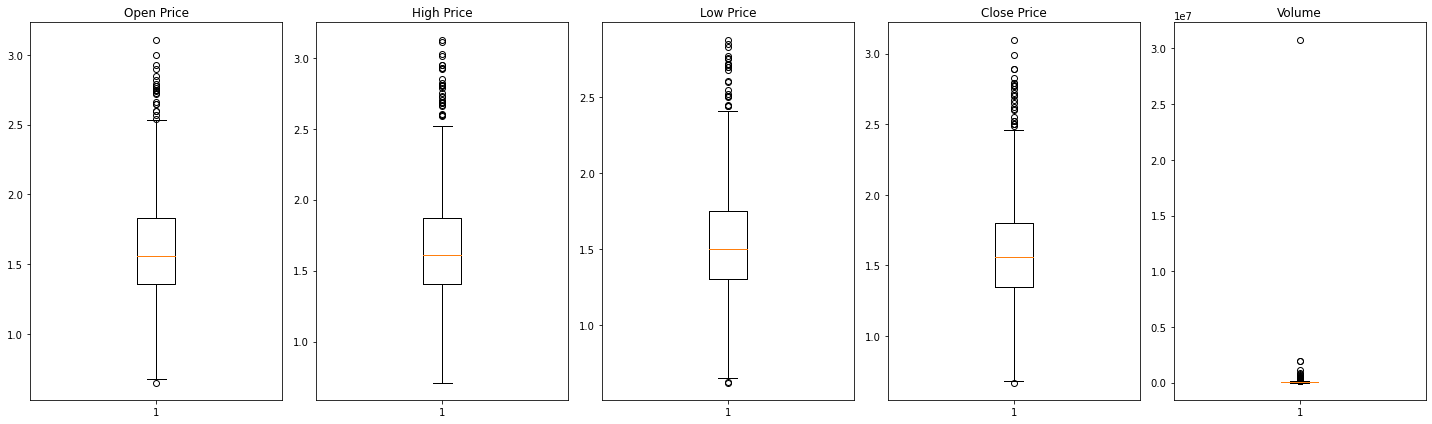

In [8]:
# Visualize the above descriptive statistics

# Create the Figure and Axes
fig = plt.figure(figsize=(20, 6))

# Plot the Line
ax1 = fig.add_subplot(1,5,1)
ax1.boxplot(raw_stock_data['Open'])
ax1.set_title("Open Price")

ax2 = fig.add_subplot(1,5,2)
ax2.boxplot(raw_stock_data['High'])
ax2.set_title("High Price")

ax3 = fig.add_subplot(1,5,3)
ax3.boxplot(raw_stock_data['Low'])
ax3.set_title("Low Price")

ax4 = fig.add_subplot(1,5,4)
ax4.boxplot(raw_stock_data['Close'])
ax4.set_title("Close Price")

ax5 = fig.add_subplot(1,5,5)
ax5.boxplot(raw_stock_data['Volume'])
ax5.set_title("Volume")

#Save the plot
plt.tight_layout()
plt.savefig("Ekso Boxplot Distribution", dpi=1000, bbox_inches='tight', facecolor='white')

plt.show()

- The max value of volume shows an outlier. But since we are dealing with time series data, we need to be very certain before we decide to address outliers, due to their temporal dependence. 

- I have run through several iterations of this and eventually decided not to remove volume at this stage of the process.

### Removing & Renaming Columns

In [9]:
# Removing the columns we do not need
raw_stock_data = raw_stock_data.drop(columns=['Dividends', 'Stock Splits'])

In [10]:
# Rename columns to python standard lowercase
raw_stock_data.rename({'Open':'open','High':'high','Low':'low','Close':'close', 'Volume':'volume'}, axis=1, inplace=True)

#raw_stock_data.head()

### Data Visualization

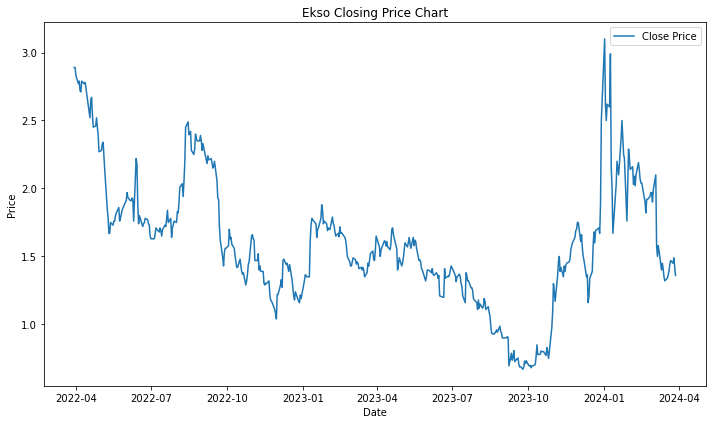

In [11]:
# Visualize our closing price

# Since the index is DatetimeIndex, matplotlib will auto-format the x-axis with appropriate date/time labels.

# Create the Figure and Axes
fig, ax = plt.subplots(figsize=(10, 6))  # Specify the figure size

# Plot the Line
ax.plot(raw_stock_data['close'], label='Close Price') 

# Customize the plot (optional)
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.set_title("Ekso Closing Price Chart")
ax.legend()

#Save the plot
plt.tight_layout()
plt.savefig("Ekso Closing Price Chart", dpi=600, bbox_inches='tight', facecolor='white')

plt.show()

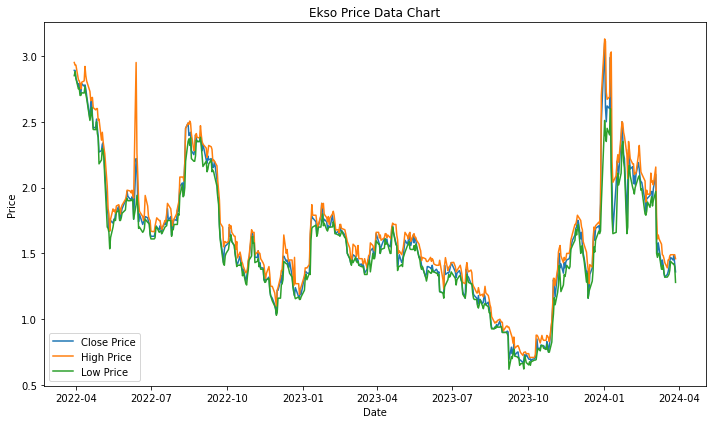

In [12]:
# Visualize all the price data
# Create the Figure and Axes
fig, ax = plt.subplots(figsize=(10, 6))  # Specify the figure size

# Plot the Line
ax.plot(raw_stock_data['close'], label='Close Price')
ax.plot(raw_stock_data['high'], label='High Price')
ax.plot(raw_stock_data['low'], label='Low Price')

# Customize the plot (optional)
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.set_title("Ekso Price Data Chart")
ax.legend()

#Save the plot
plt.tight_layout()
plt.savefig("Ekso Price Data Chart", dpi=600, bbox_inches='tight', facecolor='white')

plt.show()

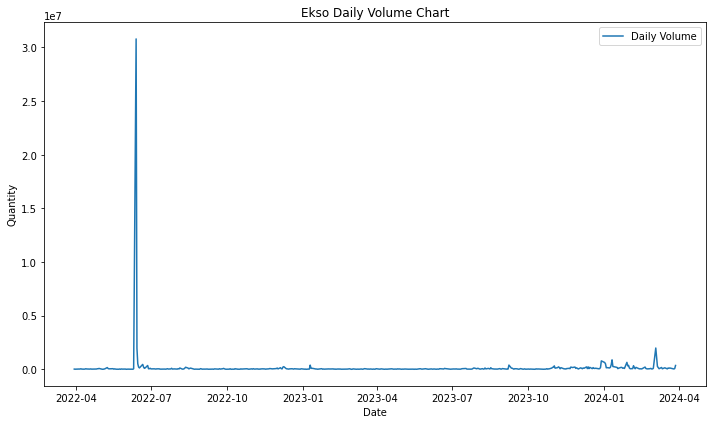

In [13]:
# Visualize all the volume
# Create the Figure and Axes
fig, ax = plt.subplots(figsize=(10, 6))  # Specify the figure size

# Plot the Line
ax.plot(raw_stock_data['volume'], label='Daily Volume')

# Customize the plot (optional)
ax.set_xlabel("Date")
ax.set_ylabel("Quantity")
ax.set_title("Ekso Daily Volume Chart")
ax.legend()

#Save the plot
plt.tight_layout()
plt.savefig("Ekso Daily Volume Chart", dpi=600, bbox_inches='tight', facecolor='white')

plt.show()

Even though it does appear an outlier exists in the volume data, I will leave this as is.

- Sometimes, especially in financial data, outliers carry valuable information that might represent meaningful market information. If the model learns from this, it might better handle unusual events in the future.

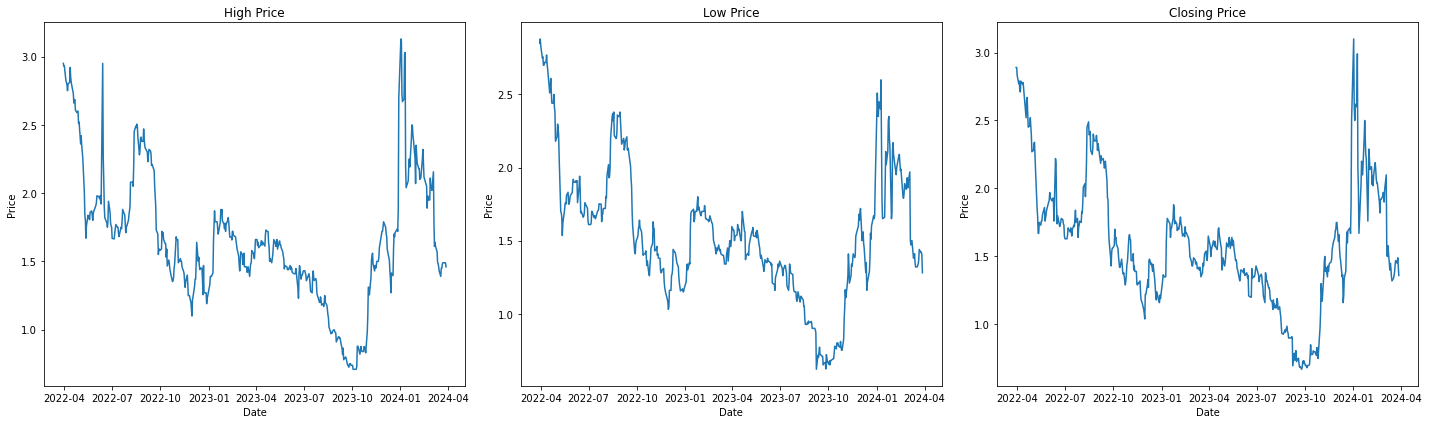

In [14]:
# After deploying my model, creating this graph to use on my website:

# Visualize high, low and closing price together

# Create the Figure and Axes
fig = plt.figure(figsize=(20, 6))

# Plot the Line
ax1 = fig.add_subplot(1,3,1)
ax1.plot(raw_stock_data['high'])
ax1.set_xlabel("Date")
ax1.set_ylabel("Price")
ax1.set_title("High Price")

ax2 = fig.add_subplot(1,3,2)
ax2.plot(raw_stock_data['low'])
ax2.set_xlabel("Date")
ax2.set_ylabel("Price")
ax2.set_title("Low Price")

ax3 = fig.add_subplot(1,3,3)
ax3.plot(raw_stock_data['close'])
ax3.set_xlabel("Date")
ax3.set_ylabel("Price")
ax3.set_title("Closing Price")


#Save the plot
plt.tight_layout()
plt.savefig("Ekso Open, High, Low, Closing Graph", dpi=1000, bbox_inches='tight', facecolor='white')

plt.show()

### Feature Engineering

Based on research from ***https://www.investopedia.com/***, I identified the 5 top technical indicators for securities/stocks. These are:

1. Simple Moving Average & Exponential Moving Averages

3. Relative Strength Index

4. Bollinger Bands

5. Moving Average Convergence Divergence

6. Stochastic Oscillator


From these, I derived the following engineered features:

In [15]:
# Simple Moving Average (SMA) - 5 days, 10 days, 15 days, 30 days

# Libraries used: pandas

# Define the window size for the SMA
duration1 = 5
duration2 = 10
duration3 = 15
duration4 = 20
duration5 = 30

# Calculate the SMAs using a rolling window
raw_stock_data['5_sma'] = raw_stock_data['close'].rolling(window=duration1).mean()
raw_stock_data['10_sma'] = raw_stock_data['close'].rolling(window=duration2).mean()
raw_stock_data['15_sma'] = raw_stock_data['close'].rolling(window=duration3).mean()
raw_stock_data['20_sma'] = raw_stock_data['close'].rolling(window=duration4).mean()
raw_stock_data['30_sma'] = raw_stock_data['close'].rolling(window=duration5).mean()

raw_stock_data.head()

,open,high,low,close,volume,5_sma,10_sma,15_sma,20_sma,30_sma
Date,,,,,,,,,,
2022-03-30 00:00:00-04:00,2.85,2.95,2.850,2.89,22200,NaN,NaN,NaN,NaN,NaN
2022-03-31 00:00:00-04:00,2.90,2.93,2.880,2.89,12500,NaN,NaN,NaN,NaN,NaN
2022-04-01 00:00:00-04:00,2.93,2.93,2.830,2.83,16600,NaN,NaN,NaN,NaN,NaN
2022-04-04 00:00:00-04:00,2.78,2.82,2.750,2.77,27500,NaN,NaN,NaN,NaN,NaN
2022-04-05 00:00:00-04:00,2.79,2.81,2.758,2.79,27700,2.834,NaN,NaN,NaN,NaN


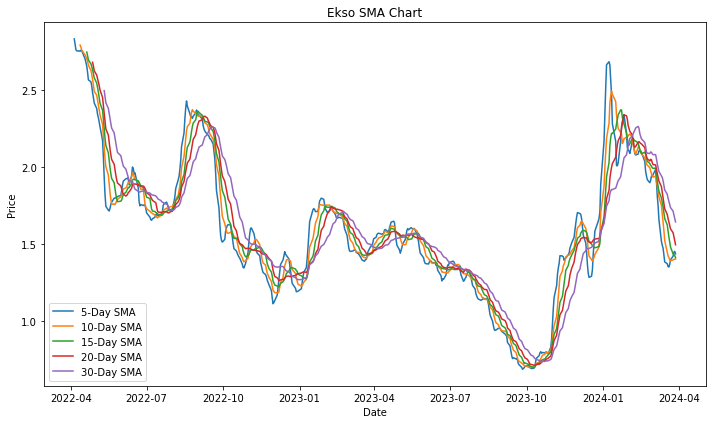

In [16]:
# Visualize all the SMAs

fig, ax = plt.subplots(figsize=(10, 6))  # Specify the figure size

# Plot the Line
ax.plot(raw_stock_data['5_sma'], label='5-Day SMA')
ax.plot(raw_stock_data['10_sma'], label='10-Day SMA')
ax.plot(raw_stock_data['15_sma'], label='15-Day SMA')
ax.plot(raw_stock_data['20_sma'], label='20-Day SMA')
ax.plot(raw_stock_data['30_sma'], label='30-Day SMA')


# Customize the plot (optional)
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.set_title("Ekso SMA Chart")
ax.legend()

#Save the plot
plt.tight_layout()
plt.savefig("Ekso SMA Chart", dpi=600, bbox_inches='tight', facecolor='white')

plt.show()

In [17]:
# Exponential Moving Average - 10 days

def calculate_ema(data, period):
    smoothing_factor = 2 / (period + 1)
    ema = data.ewm(span=period, adjust=False).mean()
    return ema

# Calculate EMA and add values to new column
period = 10
raw_stock_data[str(period) +'_ema'] = calculate_ema(raw_stock_data['close'], period)

raw_stock_data.head()

,open,high,low,close,volume,5_sma,10_sma,15_sma,20_sma,30_sma,10_ema
Date,,,,,,,,,,,
2022-03-30 00:00:00-04:00,2.85,2.95,2.850,2.89,22200,NaN,NaN,NaN,NaN,NaN,2.890000
2022-03-31 00:00:00-04:00,2.90,2.93,2.880,2.89,12500,NaN,NaN,NaN,NaN,NaN,2.890000
2022-04-01 00:00:00-04:00,2.93,2.93,2.830,2.83,16600,NaN,NaN,NaN,NaN,NaN,2.879091
2022-04-04 00:00:00-04:00,2.78,2.82,2.750,2.77,27500,NaN,NaN,NaN,NaN,NaN,2.859256
2022-04-05 00:00:00-04:00,2.79,2.81,2.758,2.79,27700,2.834,NaN,NaN,NaN,NaN,2.846664


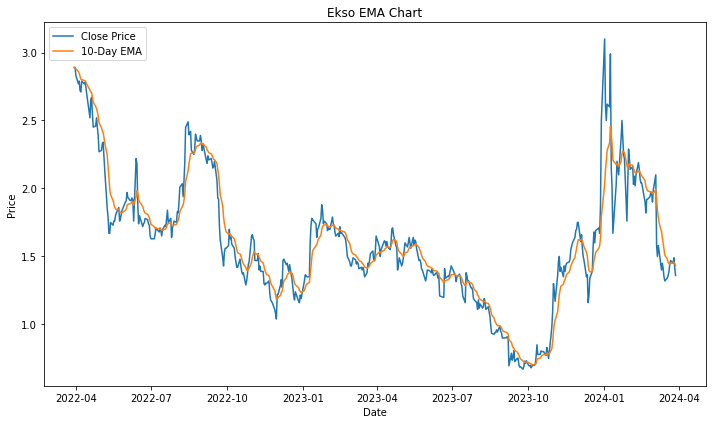

In [18]:
# Visualize the EMA

fig, ax = plt.subplots(figsize=(10, 6))  # Specify the figure size

# Plot the Line
ax.plot(raw_stock_data['close'], label='Close Price') 
ax.plot(raw_stock_data['10_ema'], label='10-Day EMA')

# Customize the plot (optional)
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.set_title("Ekso EMA Chart")
ax.legend()

#Save the plot
plt.tight_layout()
plt.savefig("Ekso EMA Chart", dpi=600, bbox_inches='tight', facecolor='white')

plt.show()

In [19]:
#Relative Srength Index

def calculate_rsi(data, column_name, period):
    delta = data[column_name].diff()
    gains = delta.clip(lower=0)
    losses = -delta.clip(upper=0)

    avg_gain = gains.ewm(alpha=1/period, min_periods=period).mean()
    avg_loss = losses.ewm(alpha=1/period, min_periods=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi 

# Calculate EMA and add values to new column
period = 14
raw_stock_data['rsi'] = calculate_rsi(raw_stock_data,'close', 14)

raw_stock_data.head(20)

,open,high,low,close,volume,5_sma,10_sma,15_sma,20_sma,30_sma,10_ema,rsi
Date,,,,,,,,,,,,
2022-03-30 00:00:00-04:00,2.85,2.950,2.850,2.890,22200,NaN,NaN,NaN,NaN,NaN,2.890000,NaN
2022-03-31 00:00:00-04:00,2.90,2.930,2.880,2.890,12500,NaN,NaN,NaN,NaN,NaN,2.890000,NaN
2022-04-01 00:00:00-04:00,2.93,2.930,2.830,2.830,16600,NaN,NaN,NaN,NaN,NaN,2.879091,NaN
2022-04-04 00:00:00-04:00,2.78,2.820,2.750,2.770,27500,NaN,NaN,NaN,NaN,NaN,2.859256,NaN
2022-04-05 00:00:00-04:00,2.79,2.810,2.758,2.790,27700,2.8340,NaN,NaN,NaN,NaN,2.846664,NaN
2022-04-06 00:00:00-04:00,2.75,2.790,2.700,2.720,23200,2.8000,NaN,NaN,NaN,NaN,2.823634,NaN
2022-04-07 00:00:00-04:00,2.75,2.750,2.700,2.710,52500,2.7640,NaN,NaN,NaN,NaN,2.802974,NaN
2022-04-08 00:00:00-04:00,2.74,2.800,2.720,2.790,22400,2.7560,NaN,NaN,NaN,NaN,2.800615,NaN
2022-04-11 00:00:00-04:00,2.78,2.810,2.718,2.770,13900,2.7560,NaN,NaN,NaN,NaN,2.795048,NaN


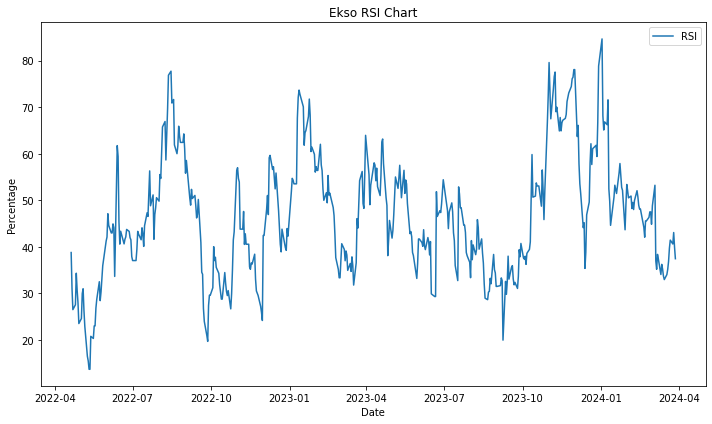

In [20]:
# Visualize the RSI

fig, ax = plt.subplots(figsize=(10, 6))  # Specify the figure size

# Plot the Line
ax.plot(raw_stock_data['rsi'], label='RSI') 

# Customize the plot (optional)
ax.set_xlabel("Date")
ax.set_ylabel("Percentage")
ax.set_title("Ekso RSI Chart")
ax.legend()

#Save the plot
plt.tight_layout()
plt.savefig("Ekso RSI Chart", dpi=600, bbox_inches='tight', facecolor='white')

plt.show()

In [21]:
# Bollinger Bands
# Libraries used: pandas, numpy

# Bollinger Band calculation
period = 20  # Common period for Bollinger Bands
std_multiplier = 2  # Standard deviations multiplier

# Calculate standard deviation
raw_stock_data['bollinger_std'] = raw_stock_data['close'].rolling(window=period).std()

# Calculate Upper and Lower Bollinger Bands
raw_stock_data['bollinger_upper'] = raw_stock_data['30_sma'] + (raw_stock_data['bollinger_std'] * std_multiplier)
raw_stock_data['bollinger_lower'] = raw_stock_data['30_sma'] - (raw_stock_data['bollinger_std'] * std_multiplier)

#raw_stock_data.head()

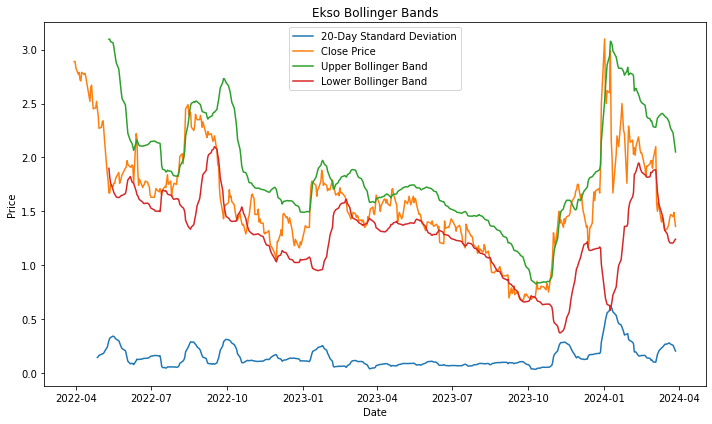

In [22]:
# Visualize the Bollinger Bands

fig, ax = plt.subplots(figsize=(10, 6))  # Specify the figure size

# Plot the Line
ax.plot(raw_stock_data['bollinger_std'], label='20-Day Standard Deviation')
ax.plot(raw_stock_data['close'], label='Close Price')
ax.plot(raw_stock_data['bollinger_upper'], label='Upper Bollinger Band') 
ax.plot(raw_stock_data['bollinger_lower'], label='Lower Bollinger Band') 

# Customize the plot (optional)
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.set_title("Ekso Bollinger Bands")
ax.legend()

#Save the plot
plt.tight_layout()
plt.savefig("Ekso Bollinger Bands", dpi=600, bbox_inches='tight', facecolor='white')

plt.show()

In [23]:
# MACD (Moving Average Convergence Divergence) 
# Libraries used: pandas

# Calculate MACD
fast_period = 12
slow_period = 26
signal_period = 9

# Calculate Exponential Moving Averages
raw_stock_data['ema_fast'] = raw_stock_data['close'].ewm(span=fast_period, adjust=False).mean() 
raw_stock_data['ema_slow'] = raw_stock_data['close'].ewm(span=slow_period, adjust=False).mean()

# Calculate MACD Line
raw_stock_data['macd'] = raw_stock_data['ema_fast'] - raw_stock_data['ema_slow']

# Calculate Signal Line
raw_stock_data['macd_signal'] = raw_stock_data['macd'].ewm(span=signal_period, adjust=False).mean()

# Calculate Histogram
raw_stock_data['macd_histogram'] = raw_stock_data['macd'] - raw_stock_data['macd_signal']

#raw_stock_data.head()

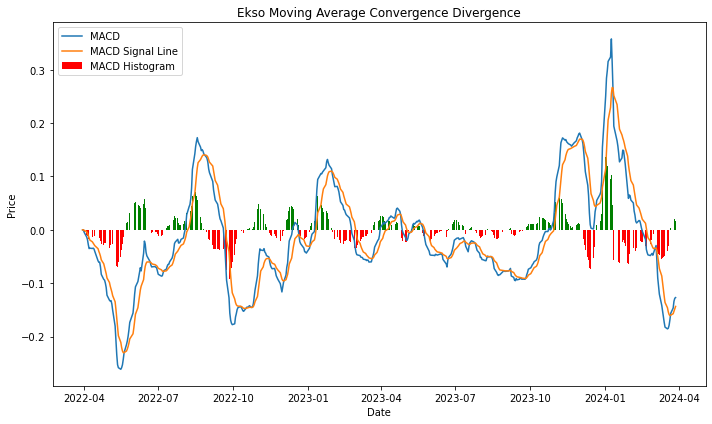

In [24]:
# Visualize the MACD (Moving Average Convergence Divergence) 

fig, ax = plt.subplots(figsize=(10, 6))  # Specify the figure size

# Plot the Line
ax.plot(raw_stock_data['macd'], label='MACD')
ax.plot(raw_stock_data['macd_signal'], label='MACD Signal Line') 
ax.bar(raw_stock_data.index, raw_stock_data['macd_histogram'],
       color=['green' if val > 0 else 'red' for val in raw_stock_data['macd_histogram']], label='MACD Histogram') 

# Customize the plot (optional)
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.set_title("Ekso Moving Average Convergence Divergence")
ax.legend()

#Save the plot
plt.tight_layout()
plt.savefig("Ekso Moving Average Convergence Divergence", dpi=600, bbox_inches='tight', facecolor='white')

plt.show()

In [25]:
# Stochastic Oscillator
# Libraries used: pandas, numpy

# Stochastic Oscillator calculation
period = 14   # Standard lookback period
smooth_k = 3  # Smoothing for %K
smooth_d = 3  # Smoothing for %D

# Calculate Lowest Low and Highest High
raw_stock_data['stochastic_lowest_low'] = raw_stock_data['low'].rolling(window=period).min()
raw_stock_data['stochastic_highest_high'] = raw_stock_data['high'].rolling(window=period).max()

# Calculate %K
raw_stock_data['pct_k'] = 100 * (raw_stock_data['close'] - raw_stock_data['stochastic_lowest_low'])/(raw_stock_data['stochastic_highest_high'] - raw_stock_data['stochastic_lowest_low'])

# Calculate %D (smoothed %K)
raw_stock_data['pct_d'] = raw_stock_data['pct_k'].rolling(window=smooth_d).mean()

#raw_stock_data.head()

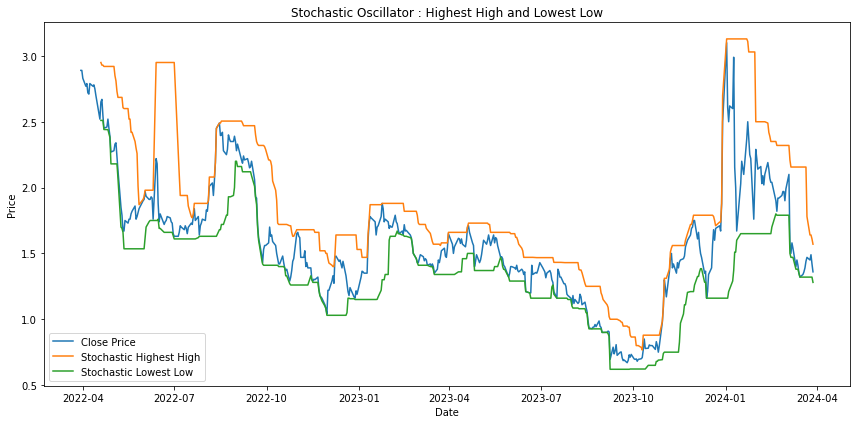

In [26]:
# After deploying my model, creating this graph to use on my website:

# Visualize the Stochastic Oscillator Highest High and Lowest Low

fig, ax = plt.subplots(figsize=(12, 6))  # Specify the figure size

# Plot the Line
ax.plot(raw_stock_data['close'], label='Close Price')
ax.plot(raw_stock_data['stochastic_highest_high'], label='Stochastic Highest High') 
ax.plot(raw_stock_data['stochastic_lowest_low'], label='Stochastic Lowest Low') 

# Customize the plot (optional)
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.set_title("Stochastic Oscillator : Highest High and Lowest Low")
ax.legend()

#Save the plot
plt.tight_layout()
plt.savefig("Ekso Stochastic Oscillator", dpi=600, bbox_inches='tight', facecolor='white')

plt.show()

#### Creating Lags

- Lags are particularly valuable when differencing needs to be done to achieve stationarity. This is because differencing removes some of the autocorrelation structure, and lagged variables helps the autocorrelation structures penetrate through the differencing process.

- Lagged variables incorporated as features will potentially enhance the ability of my selected models to uncover time-dependent patterns.

In [27]:
# Create lag feature
raw_stock_data['open_lag_1'] = raw_stock_data['open'].shift(1)
raw_stock_data['open_lag_2'] = raw_stock_data['open'].shift(2)


raw_stock_data['close_lag_1'] = raw_stock_data['close'].shift(1)
raw_stock_data['close_lag_2'] = raw_stock_data['close'].shift(2)


### Get  market sentiment data

To uncover market sentiment, I will first explore how the chosen stock moves in relation to the selected benchmark, the S&P 500.

**Note**

**[Beta](https://www.investopedia.com/terms/b/beta.asp)** is a metric that is used to uncover the reveal how sensitive a security is to the overall fluctuations in the market


I have selected the S&P 500 as my benchmark. According to the resource linked above:

- Beta Greater than 1 implies an 'Aggressive Security', hence more volatile than the S&P 500.

- Beta equal to 1 implies a security that is similar the S&P 500.

- Beta less than 1 implies a 'Defensive Security', hence less volatile than the S&P 500.

In [29]:
# Checking the beta

stock_ticker = "EKSO"
benchmark_ticker = "^GSPC"  # S&P 500 as a benchmark

stock_data = yf.download(stock_ticker, period="2y")
benchmark_data = yf.download(benchmark_ticker, period="2y")

stock_returns = stock_data['Adj Close'].pct_change().dropna()
benchmark_returns = benchmark_data['Adj Close'].pct_change().dropna()

covariance = np.cov(stock_returns, benchmark_returns)[0][1] 
benchmark_variance = np.var(benchmark_returns)

beta = covariance / benchmark_variance
print("Beta:", beta)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Beta: 0.5872261610798659


Based on the beta above, our stock EKSO appears to be less volatile than the benchmark/market conditions. This might potentially indicate a low Collinearity between than two. 

Non-the-less, let's capture the S&P 500 data and we will definitively test for Collinearity later on.

In [30]:
# Create a ticker object for VIX
sp500 = yf.Ticker("^GSPC")

# Get historical market data for exactly the same dates as our stock data
hist_sp500 = sp500.history(start="2022-03-30", end="2024-03-29")

# Save the historical market data to CSV
hist_sp500.to_csv("hist_sp500.csv")

In [31]:
# Load the sentiment indicator, set Date column as index
hist_sp500 = pd.read_csv('hist_sp500.csv', index_col='Date')

# Convert index to datetime
hist_sp500.index = pd.to_datetime(hist_sp500.index)

#hist_sp500.head()

In [32]:
# Removing the columns that are not needed

hist_sp500 = hist_sp500.drop(columns=['Dividends', 'Stock Splits'])

In [33]:
# Rename remaining columns
hist_sp500.rename({'Open':'sp500_open','High':'sp500_high','Low':'sp500_low','Close':'sp500_close', 'Volume':'sp500_volume'}, axis=1, inplace=True)

#hist_sp500.head()

In [34]:
# Combine both DataFrames
combined_stock = pd.concat([raw_stock_data,hist_sp500], axis=1)

combined_stock

,open,high,low,close,volume,5_sma,10_sma,15_sma,20_sma,30_sma,...,pct_d,open_lag_1,open_lag_2,close_lag_1,close_lag_2,sp500_open,sp500_high,sp500_low,sp500_close,sp500_volume
Date,,,,,,,,,,,,,,,,,,,,,
2022-03-30 00:00:00-04:00,2.85,2.95,2.850,2.89,22200,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4624.200195,4627.770020,4581.319824,4602.450195,4385570000
2022-03-31 00:00:00-04:00,2.90,2.93,2.880,2.89,12500,NaN,NaN,NaN,NaN,NaN,...,NaN,2.85,NaN,2.89,NaN,4599.020020,4603.069824,4530.410156,4530.410156,4823020000
2022-04-01 00:00:00-04:00,2.93,2.93,2.830,2.83,16600,NaN,NaN,NaN,NaN,NaN,...,NaN,2.90,2.85,2.89,2.89,4540.319824,4548.700195,4507.569824,4545.859863,4562940000
2022-04-04 00:00:00-04:00,2.78,2.82,2.750,2.77,27500,NaN,NaN,NaN,NaN,NaN,...,NaN,2.93,2.90,2.83,2.89,4547.970215,4583.500000,4539.209961,4582.640137,4547350000
2022-04-05 00:00:00-04:00,2.79,2.81,2.758,2.79,27700,2.834,NaN,NaN,NaN,NaN,...,NaN,2.78,2.93,2.77,2.83,4572.450195,4593.450195,4514.169922,4525.120117,4800620000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-22 00:00:00-04:00,1.44,1.49,1.440,1.47,106600,1.400,1.393,1.482000,1.6000,1.738000,...,18.445322,1.42,1.36,1.44,1.39,5242.479980,5246.089844,5229.870117,5234.180176,3374700000
2024-03-25 00:00:00-04:00,1.49,1.49,1.420,1.45,57300,1.422,1.398,1.438667,1.5755,1.716333,...,29.195924,1.44,1.42,1.47,1.44,5219.520020,5229.089844,5216.089844,5218.189941,3331360000
2024-03-26 00:00:00-04:00,1.44,1.49,1.421,1.49,32900,1.448,1.402,1.432667,1.5515,1.693000,...,42.119567,1.49,1.44,1.45,1.47,5228.850098,5235.160156,5203.419922,5203.580078,3871790000


### The Response Variable

By using shift() , the response variable is created. This is the next days closing price that we want our final model to predict.

In a real world setting, one can use this model to run predictions for the next days closing price after the market closes for the current day.

In [35]:
# Adding the response

combined_stock['next_day_close'] = combined_stock['close'].shift(-1)

#combined_stock.head()

###  Handling Missing Data

As a result of the feature engineering done above, new Nan values were created. These need to be resolved. 

#### Filtering missing data

In [36]:
# Counting missing values per column

missing_counts = combined_stock.isnull().sum()
missing_counts

open                        0
high                        0
low                         0
close                       0
volume                      0
5_sma                       4
10_sma                      9
15_sma                     14
20_sma                     19
30_sma                     29
10_ema                      0
rsi                        14
bollinger_std              19
bollinger_upper            29
bollinger_lower            29
ema_fast                    0
ema_slow                    0
macd                        0
macd_signal                 0
macd_histogram              0
stochastic_lowest_low      13
stochastic_highest_high    13
pct_k                      13
pct_d                      15
open_lag_1                  1
open_lag_2                  2
close_lag_1                 1
close_lag_2                 2
sp500_open                  0
sp500_high                  0
sp500_low                   0
sp500_close                 0
sp500_volume                0
next_day_c

In [37]:
# Percentage of missing values per column

missing_percentage = missing_counts / len(combined_stock) * 100
print(missing_percentage)

open                       0.000000
high                       0.000000
low                        0.000000
close                      0.000000
volume                     0.000000
5_sma                      0.796813
10_sma                     1.792829
15_sma                     2.788845
20_sma                     3.784861
30_sma                     5.776892
10_ema                     0.000000
rsi                        2.788845
bollinger_std              3.784861
bollinger_upper            5.776892
bollinger_lower            5.776892
ema_fast                   0.000000
ema_slow                   0.000000
macd                       0.000000
macd_signal                0.000000
macd_histogram             0.000000
stochastic_lowest_low      2.589641
stochastic_highest_high    2.589641
pct_k                      2.589641
pct_d                      2.988048
open_lag_1                 0.199203
open_lag_2                 0.398406
close_lag_1                0.199203
close_lag_2                0

In [38]:
# Count total rows with missing values
num_rows_with_missing = combined_stock.isnull().any(axis=1).sum() 
print("Total number of rows that have missing values: ", num_rows_with_missing)

Total number of rows that have missing values:  30


In [39]:
# Dropping rows with missing data
clean_stock_data = combined_stock.dropna()

# Confirm rows with missing values are removed
final_num_rows_with_missing = clean_stock_data.isnull().any(axis=1).sum() 
print("Total number of rows that have missing values: ", final_num_rows_with_missing)

Total number of rows that have missing values:  0


In [40]:
# One more quick check on the distribution of our data
clean_stock_data.describe()

,open,high,low,close,volume,5_sma,10_sma,15_sma,20_sma,30_sma,...,open_lag_1,open_lag_2,close_lag_1,close_lag_2,sp500_open,sp500_high,sp500_low,sp500_close,sp500_volume,next_day_close
count,472.000000,472.000000,472.000000,472.000000,4.720000e+02,472.000000,472.000000,472.000000,472.000000,472.000000,...,472.000000,472.000000,472.000000,472.000000,472.000000,472.000000,472.000000,472.000000,4.720000e+02,472.000000
mean,1.549364,1.607089,1.491992,1.543388,1.418023e+05,1.545371,1.549633,1.554717,1.559922,1.569505,...,1.550042,1.551229,1.544172,1.544934,4246.485969,4272.653606,4221.294083,4248.880767,4.172724e+09,1.542731
std,0.413507,0.431916,0.393265,0.417214,1.423312e+06,0.407627,0.400793,0.395906,0.392866,0.390755,...,0.413671,0.414158,0.417329,0.417559,383.037627,377.324832,389.689715,384.345077,8.311408e+08,0.417258
min,0.650000,0.710000,0.620000,0.670000,3.700000e+03,0.688200,0.699600,0.699533,0.714350,0.736267,...,0.650000,0.650000,0.670000,0.670000,3520.370117,3608.340088,3491.580078,3577.030029,1.639500e+09,0.670000
25%,1.350000,1.390000,1.290000,1.340000,1.987500e+04,1.333500,1.335475,1.335583,1.333500,1.342450,...,1.350000,1.350000,1.340000,1.340000,3960.435059,3990.004944,3928.750061,3961.292419,3.752312e+09,1.340000
50%,1.500000,1.590000,1.470000,1.500000,3.675000e+04,1.518000,1.531500,1.537133,1.538100,1.535033,...,1.510000,1.525000,1.500000,1.510000,4143.995117,4166.140137,4118.870117,4145.900146,4.016800e+09,1.500000
75%,1.760000,1.800000,1.700000,1.750000,6.810000e+04,1.754500,1.761000,1.798500,1.823950,1.843467,...,1.762500,1.770000,1.750000,1.750000,4487.315063,4500.715088,4459.560181,4480.387329,4.414318e+09,1.750000
max,3.110000,3.129000,2.600000,3.100000,3.079240e+07,2.686000,2.495500,2.373000,2.349950,2.497967,...,3.110000,3.110000,3.100000,3.100000,5253.430176,5261.100098,5240.660156,5248.490234,9.354280e+09,3.100000


### Export final pandas DataFrame to csv

In [41]:
clean_stock_data.to_csv('clean_stock_data.csv', index=True) 

This is the End of this Notebook